# Задание 1. Классификация

---


## Этапы:
1. Генерация синтетических данных с помощью make_blobs
2. Разделение на train/test
3. Визуализация данных
4. Масштабирование данных
5. Построение моделей (Logistic Regression, SVM, Decision Tree, Random Forest)
6. Подбор гиперпараметров (GridSearchCV)
7. Оценка качества моделей (коэффициент Джини)

---


In [42]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler

---

### 1. Генерация данных(блоки)

In [43]:
x, y = make_blobs(n_samples=1000, centers=2, n_features=2, cluster_std=3.8, center_box=(-6.0, 6.0), random_state=12)

---

### 2. Разделение данных (train 70/ test 30)

In [44]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=12, stratify=y)

---

### 3. Визуализация данных

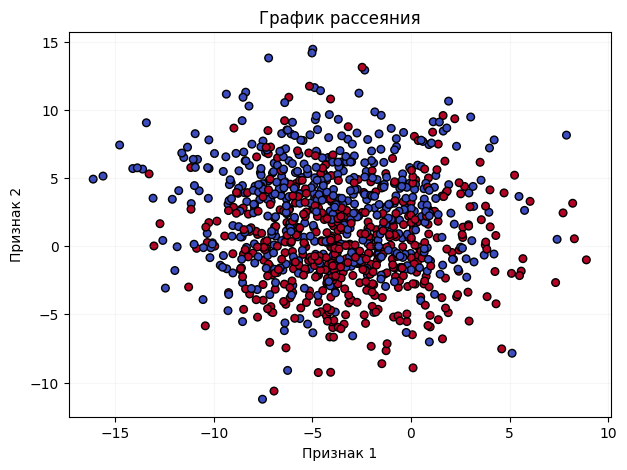

In [45]:
plt.figure(figsize=(7, 5))
plt.scatter(x[:, 0], x[:, 1], c=y, cmap='coolwarm', s=30, edgecolors='k')
plt.title("График рассеяния")
plt.xlabel("Признак 1")
plt.ylabel("Признак 2")
plt.grid(alpha=0.1)
plt.show()

---

### 4, 5. Масштабирование данных, построение моделей


In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

models = {
    "Logistic Regression": (
        Pipeline(
            [('scaler', StandardScaler()), ('clf', LogisticRegression(solver='liblinear', random_state=12))]),
        {'clf__C': [0.1, 1, 10]}
    ),
    "SVM": (
        Pipeline([('scaler', StandardScaler()), ('clf', SVC(kernel='rbf', probability=True, random_state=12))]),
        {'clf__C': [0.1, 1, 10], "clf__gamma": [0.1, 0.1, 1]}
    ),
    "DecisionTree": (
        DecisionTreeClassifier(random_state=12),
        {'max_depth': [5, 10, 20], 'min_samples_split': [2, 5, 10]}
    ),
    "RandomForest": (
        RandomForestClassifier(random_state=12),
        {'n_estimators': [10, 50, 100], 'max_depth': [5, 10, 20]}
    )
}

---

### 6, 7. Подбор гиперпараметров (GridSearchCV), оценка качества моделей (коэффициент Джини)

In [47]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)  # Стратегия кросс-валидации(5-10)
results = []
for name, (estimator, params) in models.items():
    print(f"Тренируем модель: {name}")
    # Поиск по сетке гиперпараметров с оптимизацией ROC-AUC
    gs = GridSearchCV(estimator=estimator, param_grid=params, scoring="roc_auc", cv=cv,
                      n_jobs=-1)  # n_jobs = -1 задействует все ядра процессора
    gs.fit(x_train, y_train)
    best = gs.best_estimator_
    if hasattr(best, "predict_proba"):
        probs = best.predict_proba(x_test)[:, 1]  # Матрица вероятностей
    else:
        try:
            scores = best.decision_function(x_test)
            probs = (scores - scores.min()) / (scores.max() - scores.min())  # Квалификация с нормализацией
        except Exception:
            probs = best.predict(x_test)  # Жесткая квалификация(метки класса)
    auc = roc_auc_score(y_test, probs)
    gini = 2 * auc - 1  # Площадь между Roc-кривой и диагональю разделить на площадь под диагональю(S под кривой ROC = AUC)
    results.append({
        'model': name,
        'best_params': gs.best_params_,
        'AUC': auc,  # > 0.7 среднее > 0.8 хорошее
        'Gini': gini,  # > 0.4 средне > 0.5 хорошо
    })
    print(f"Лучшие параметры: {gs.best_params_}, AUC: {auc:.4f}, Gini: {gini:.4f}")


Тренируем модель: Logistic Regression
Лучшие параметры: {'clf__C': 0.1}, AUC: 0.7228, Gini: 0.4457
Тренируем модель: SVM
Лучшие параметры: {'clf__C': 0.1, 'clf__gamma': 0.1}, AUC: 0.7261, Gini: 0.4523
Тренируем модель: DecisionTree
Лучшие параметры: {'max_depth': 5, 'min_samples_split': 5}, AUC: 0.6515, Gini: 0.3029
Тренируем модель: RandomForest
Лучшие параметры: {'max_depth': 5, 'n_estimators': 50}, AUC: 0.7096, Gini: 0.4192


In [48]:
import pandas as pd

# Вывод дисплея с результатами
df_clf = pd.DataFrame(results)
display(df_clf)

,model,best_params,AUC,Gini
0,Logistic Regression,{'clf__C': 0.1},0.722844,0.445689
1,SVM,"{'clf__C': 0.1, 'clf__gamma': 0.1}",0.726133,0.452267
2,DecisionTree,"{'max_depth': 5, 'min_samples_split': 5}",0.651467,0.302933
3,RandomForest,"{'max_depth': 5, 'n_estimators': 50}",0.709600,0.419200


In [49]:
# Сохранение таблицы
df_clf.to_csv('../data/classification_results.csv', index=False)